# LightGBM
### Parameters:
* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
* **attributes**
    * **hp**
    * **ac**
    * **perception**
* **saves**
    * **fortitude**
    * **reflex**
    * **will**
* **resources**
    * **focus**

### Prediction: *level*

## Loading data

In [45]:
import numpy as np
import pandas as pd
import sys

import os
import pathlib

sys.path.append("../../..")
from training.creating_dataset import load_and_preprocess_data

current_path = os.getcwd()
DATASETS_DIR = pathlib.Path(current_path).parent.parent.parent / "pathfinder_2e_data"
DATASET_FILES = [
    "pathfinder-bestiary.db",
    "pathfinder-bestiary-2.db",
    "pathfinder-bestiary-3.db",
]
DATASET_PATHS = [f"{DATASETS_DIR}/{file}" for file in DATASET_FILES]
features = [
    "cha",
    "con",
    "dex",
    "int",
    "str",
    "wis",
    "ac",
    "hp",
    "perception",
    "fortitude",
    "reflex",
    "will",
    "focus",
]

df = load_and_preprocess_data(
    DATASET_PATHS,
    characteristics=features,
)

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3690 entries, 0 to 4327
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ac          3690 non-null   float64
 1   perception  3690 non-null   float64
 2   hp          3690 non-null   int64  
 3   cha         3690 non-null   float64
 4   level       3690 non-null   int64  
 5   str         3690 non-null   float64
 6   int         3690 non-null   float64
 7   will        3690 non-null   float64
 8   focus       3690 non-null   int32  
 9   dex         3690 non-null   float64
 10  book        3690 non-null   object 
 11  con         3690 non-null   float64
 12  wis         3690 non-null   float64
 13  fortitude   3690 non-null   float64
 14  reflex      3690 non-null   float64
dtypes: float64(11), int32(1), int64(2), object(1)
memory usage: 446.8+ KB


In [47]:
df.head()

,ac,perception,hp,cha,level,str,int,will,focus,dex,book,con,wis,fortitude,reflex
0,28.0,18.0,155,0.0,9,6.0,0.0,20.0,1,3.0,Pathfinder #165: Eyes of Empty Death,0.0,3.0,15.0,18.0
1,30.0,19.0,175,0.0,10,7.0,0.0,19.0,0,3.0,Pathfinder Abomination Vaults Hardcover Compil...,6.0,3.0,22.0,17.0
2,17.0,7.0,38,1.0,2,4.0,-2.0,9.0,0,3.0,Pathfinder #164: Hands of the Devil,1.0,3.0,7.0,11.0
3,27.0,16.0,140,1.0,8,3.0,0.0,15.0,0,4.0,Pathfinder #164: Hands of the Devil,3.0,3.0,17.0,16.0
4,31.0,20.0,90,2.0,9,-5.0,2.0,18.0,0,6.0,Pathfinder #165: Eyes of Empty Death,0.0,4.0,14.0,21.0


###### Level

In [48]:
y = df["level"]
y

0        9
1       10
2        2
3        8
4        9
        ..
4322     2
4324     3
4325     4
4326     2
4327     2
Name: level, Length: 3690, dtype: int64

In [49]:
from collections import defaultdict


lvl_stat = defaultdict(lambda: 0)

for lvl in y:
    lvl_stat[lvl] += 1

In [50]:
level_count = pd.DataFrame(
    data={
        "lvl": [key for key in sorted(lvl_stat.keys())],
        "count": [lvl_stat.get(key) for key in sorted(lvl_stat.keys())],
    }
)
level_count

,lvl,count
0,-1,147
1,0,87
2,1,320
3,2,335
4,3,339
5,4,274
6,5,268
7,6,220
8,7,215
9,8,188


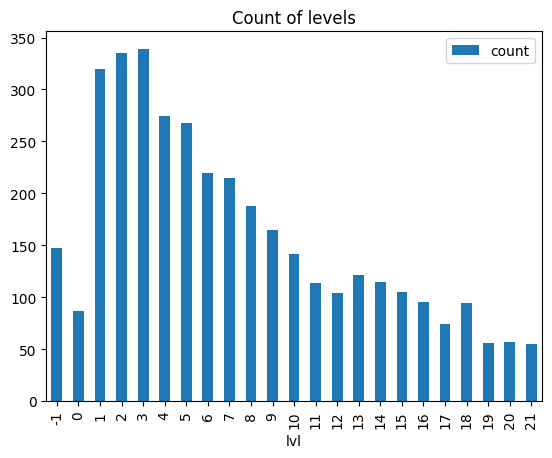

In [51]:
import matplotlib.pyplot as plt


level_count.plot.bar(x="lvl", y="count", title="Count of levels")
plt.show()

## Train test split

### Chronological split

In [52]:
from training.splitting_dataset import split_dataframe


os.chdir("../../../training")
X_train, X_test, y_train, y_test = split_dataframe(df, test_size=0.31)
os.chdir("../notebooks/models/lightgbm")

In [53]:
X_train = X_train.drop(columns=["book"])
X_test = X_test.drop(columns=["book"])

### Random split

In [54]:
(
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
) = split_dataframe(df, chronological_split=False)

In [55]:
X_train_random_split = X_train_random_split.drop(columns=["book"])
X_test_random_split = X_test_random_split.drop(columns=["book"])

## LightGBM

## Chronological split

In [56]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 426
[LightGBM] [Info] Number of data points in the train set: 1626, number of used features: 13
[LightGBM] [Info] Start training from score 7.212177
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.377336	valid_0's l1: 0.376859


In [57]:
y_pred_train = gbm.predict(X_train, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [58]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


rmse = mean_squared_error(y_test, y_pred_test, squared=False)
mae = mean_absolute_error(y_test, y_pred_test)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 0.61
MAE: 0.38


In [59]:
results = pd.DataFrame(
    data={
        "Split type": [],
        "Tuning type": [],
        "Set of features": [],
        "RMSE": [],
        "MAE": [],
    }
)

results.loc[0] = ["chronological", "default", "expanded", rmse, mae]

In [60]:
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse_test:.2f}")

RMSE train: 0.22
RMSE test: 0.61


###### MAE by level

In [61]:
from training.results import plot_mae_by_level

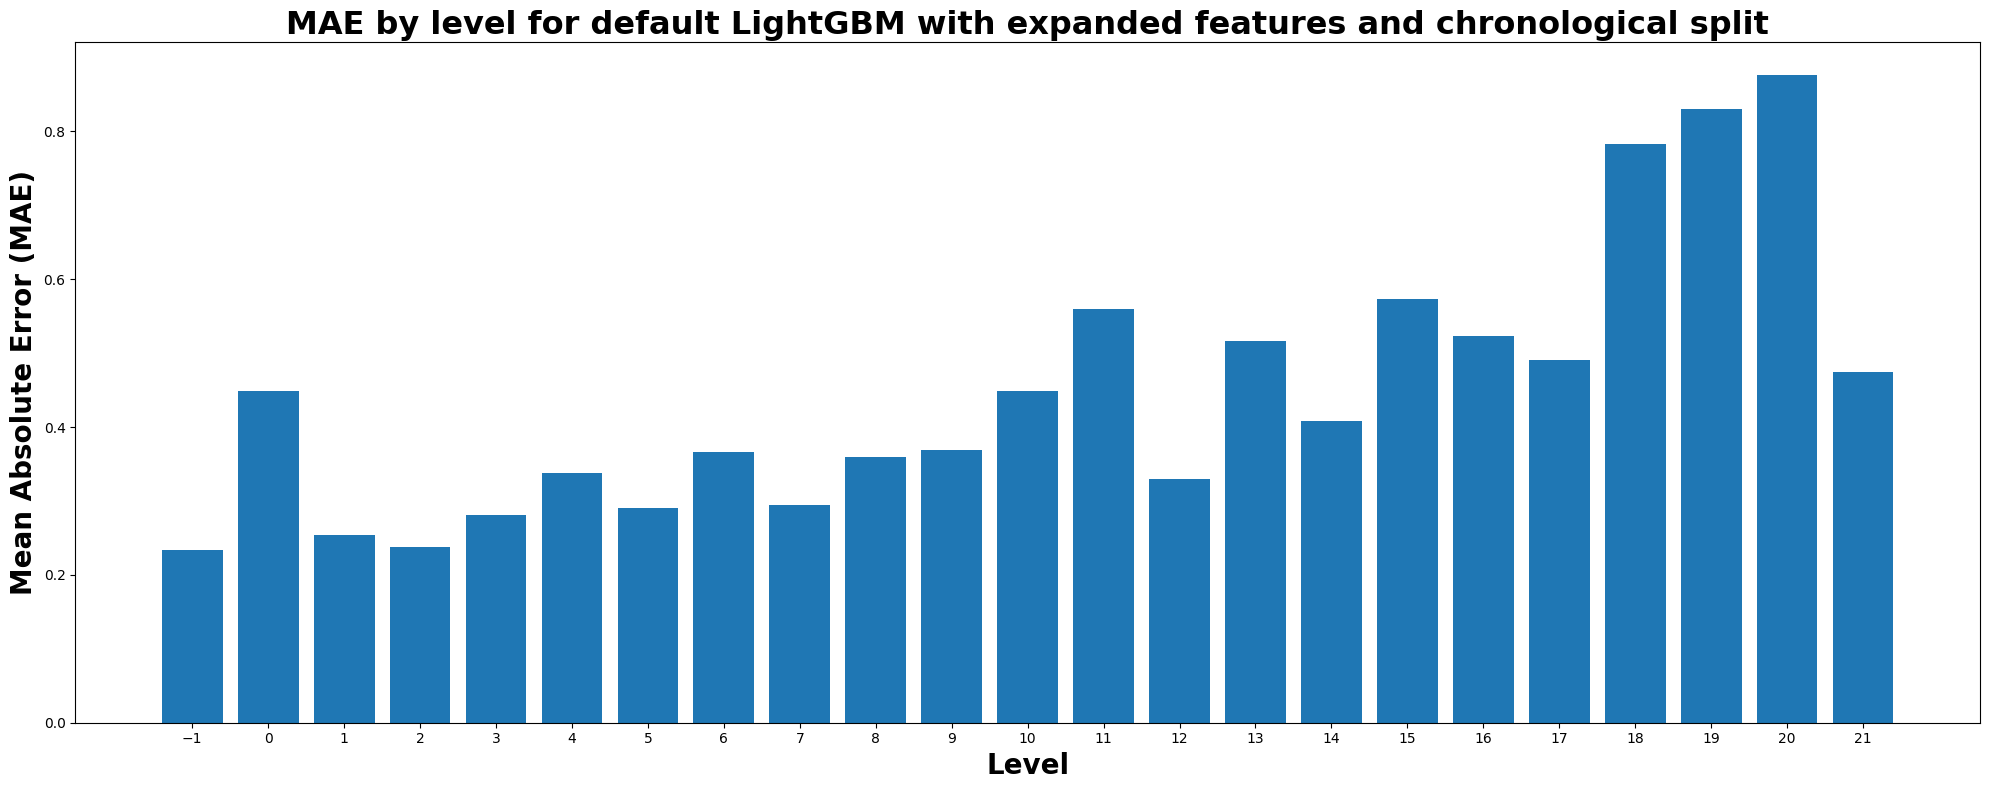

In [62]:
plot_mae_by_level(
    y_test,
    y_pred_test,
    title="MAE by level for default LightGBM with expanded features and chronological split",
)

In [63]:
from training.results import evaluate_round_predictions, plot_confusion_matrix


evaluate_round_predictions([0.5, 0.33, 0.45], y_test, y_pred_test)

Default:
RMSE: 0.61

Round type: 0.5
RMSE: 0.66

Round type: 0.33
RMSE: 0.66

Round type: 0.45
RMSE: 0.65



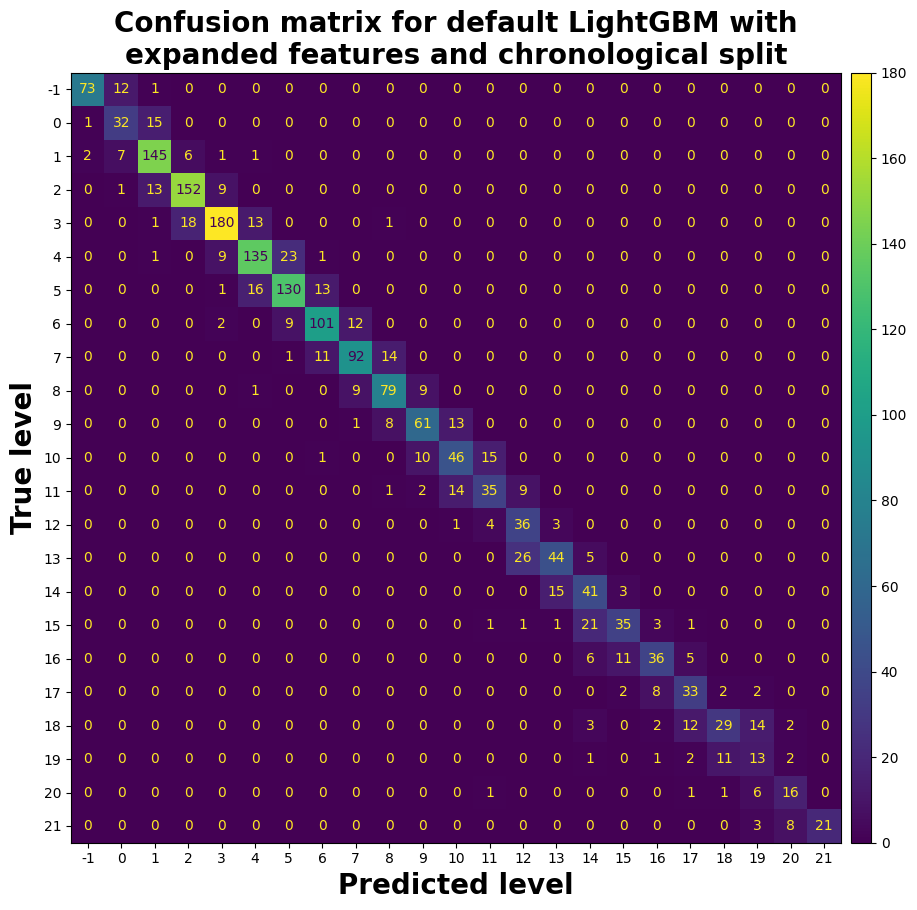

In [64]:
plot_confusion_matrix(
    y_pred_test,
    y_test,
    title="Confusion matrix for default LightGBM with\nexpanded features and chronological split",
)

#### Tuning

In [65]:
from training.results import assess_regression_model

In [66]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train, y_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-11-26 22:27:50,069] A new study created in memory with name: no-name-ff508bab-dd96-41e9-b794-9baa30c1aab9
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.207862 + 0.126772


feature_fraction, val_score: 0.207049:  14%|#4        | 1/7 [00:02<00:14,  2.42s/it]

[200]	cv_agg's l2: 0.208429 + 0.123764
Early stopping, best iteration is:
[117]	cv_agg's l2: 0.207049 + 0.126377
[100]	cv_agg's l2: 0.206563 + 0.121396
[200]	cv_agg's l2: 0.202629 + 0.11618
[300]	cv_agg's l2: 0.202885 + 0.115506
Early stopping, best iteration is:
[220]	cv_agg's l2: 0.202134 + 0.116187


feature_fraction, val_score: 0.202134:  29%|##8       | 2/7 [00:06<00:16,  3.32s/it]

[100]	cv_agg's l2: 0.201684 + 0.109977
[200]	cv_agg's l2: 0.19984 + 0.10738
[300]	cv_agg's l2: 0.20065 + 0.106098


feature_fraction, val_score: 0.199603:  43%|####2     | 3/7 [00:10<00:15,  3.90s/it]

Early stopping, best iteration is:
[216]	cv_agg's l2: 0.199603 + 0.106828
[100]	cv_agg's l2: 0.217303 + 0.136897
[200]	cv_agg's l2: 0.212319 + 0.132637


feature_fraction, val_score: 0.199603:  57%|#####7    | 4/7 [00:15<00:12,  4.07s/it]

[300]	cv_agg's l2: 0.212483 + 0.131496
Early stopping, best iteration is:
[216]	cv_agg's l2: 0.199603 + 0.106828
[100]	cv_agg's l2: 0.198334 + 0.110134
[200]	cv_agg's l2: 0.193552 + 0.106291
[300]	cv_agg's l2: 0.193855 + 0.105201


feature_fraction, val_score: 0.193223:  71%|#######1  | 5/7 [00:18<00:07,  3.80s/it]

Early stopping, best iteration is:
[264]	cv_agg's l2: 0.193223 + 0.105548
[100]	cv_agg's l2: 0.216042 + 0.134823
[200]	cv_agg's l2: 0.214086 + 0.13298
[300]	cv_agg's l2: 0.215488 + 0.131245


feature_fraction, val_score: 0.193223:  86%|########5 | 6/7 [00:22<00:03,  3.85s/it]

Early stopping, best iteration is:
[264]	cv_agg's l2: 0.193223 + 0.105548
[100]	cv_agg's l2: 0.215973 + 0.124784
[200]	cv_agg's l2: 0.212815 + 0.123507
[300]	cv_agg's l2: 0.21387 + 0.122787


feature_fraction, val_score: 0.193223: 100%|##########| 7/7 [00:26<00:00,  3.76s/it]


Early stopping, best iteration is:
[264]	cv_agg's l2: 0.193223 + 0.105548


num_leaves, val_score: 0.193223:   0%|          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.197751 + 0.106676
[200]	cv_agg's l2: 0.194097 + 0.10548
[300]	cv_agg's l2: 0.195975 + 0.103891


num_leaves, val_score: 0.193223:   5%|5         | 1/20 [00:04<01:29,  4.74s/it]

Early stopping, best iteration is:
[264]	cv_agg's l2: 0.193223 + 0.105548
[100]	cv_agg's l2: 0.198776 + 0.110169
[200]	cv_agg's l2: 0.19438 + 0.106554
[300]	cv_agg's l2: 0.195389 + 0.10445


num_leaves, val_score: 0.193223:  10%|#         | 2/20 [00:08<01:15,  4.22s/it]

Early stopping, best iteration is:
[264]	cv_agg's l2: 0.193223 + 0.105548
[100]	cv_agg's l2: 0.197751 + 0.106676
[200]	cv_agg's l2: 0.194097 + 0.10548
[300]	cv_agg's l2: 0.195975 + 0.103891


num_leaves, val_score: 0.193223:  15%|#5        | 3/20 [00:14<01:21,  4.77s/it]

Early stopping, best iteration is:
[264]	cv_agg's l2: 0.193223 + 0.105548
[100]	cv_agg's l2: 0.197751 + 0.106676
[200]	cv_agg's l2: 0.194097 + 0.10548
[300]	cv_agg's l2: 0.195975 + 0.103891


num_leaves, val_score: 0.193223:  20%|##        | 4/20 [00:19<01:19,  4.98s/it]

Early stopping, best iteration is:
[264]	cv_agg's l2: 0.193223 + 0.105548
[100]	cv_agg's l2: 0.197751 + 0.106676
[200]	cv_agg's l2: 0.194097 + 0.10548
[300]	cv_agg's l2: 0.195975 + 0.103891


num_leaves, val_score: 0.193223:  25%|##5       | 5/20 [00:25<01:20,  5.36s/it]

Early stopping, best iteration is:
[264]	cv_agg's l2: 0.193223 + 0.105548
[100]	cv_agg's l2: 0.277679 + 0.127858
[200]	cv_agg's l2: 0.249655 + 0.118628
[300]	cv_agg's l2: 0.237719 + 0.115365


num_leaves, val_score: 0.193223:  30%|###       | 6/20 [00:26<00:52,  3.77s/it]

Early stopping, best iteration is:
[264]	cv_agg's l2: 0.193223 + 0.105548
[100]	cv_agg's l2: 0.197751 + 0.106676
[200]	cv_agg's l2: 0.194097 + 0.10548
[300]	cv_agg's l2: 0.195975 + 0.103891


num_leaves, val_score: 0.193223:  35%|###5      | 7/20 [00:32<00:58,  4.49s/it]

Early stopping, best iteration is:
[264]	cv_agg's l2: 0.193223 + 0.105548
[100]	cv_agg's l2: 0.197751 + 0.106676
[200]	cv_agg's l2: 0.194097 + 0.10548
[300]	cv_agg's l2: 0.195975 + 0.103891


num_leaves, val_score: 0.193223:  40%|####      | 8/20 [00:40<01:10,  5.89s/it]

Early stopping, best iteration is:
[264]	cv_agg's l2: 0.193223 + 0.105548
[100]	cv_agg's l2: 0.197751 + 0.106676
[200]	cv_agg's l2: 0.194097 + 0.10548
[300]	cv_agg's l2: 0.195975 + 0.103891


num_leaves, val_score: 0.193223:  45%|####5     | 9/20 [00:50<01:17,  7.01s/it]

Early stopping, best iteration is:
[264]	cv_agg's l2: 0.193223 + 0.105548
[100]	cv_agg's l2: 0.197751 + 0.106676
[200]	cv_agg's l2: 0.194097 + 0.10548
[300]	cv_agg's l2: 0.195975 + 0.103891


num_leaves, val_score: 0.193223:  50%|#####     | 10/20 [00:59<01:17,  7.73s/it]

Early stopping, best iteration is:
[264]	cv_agg's l2: 0.193223 + 0.105548
[100]	cv_agg's l2: 0.197751 + 0.106676
[200]	cv_agg's l2: 0.194097 + 0.10548
[300]	cv_agg's l2: 0.195975 + 0.103891


num_leaves, val_score: 0.193223:  55%|#####5    | 11/20 [01:08<01:13,  8.18s/it]

Early stopping, best iteration is:
[264]	cv_agg's l2: 0.193223 + 0.105548
[100]	cv_agg's l2: 0.197751 + 0.106676
[200]	cv_agg's l2: 0.194097 + 0.10548
[300]	cv_agg's l2: 0.195975 + 0.103891


num_leaves, val_score: 0.193223:  60%|######    | 12/20 [01:17<01:07,  8.44s/it]

Early stopping, best iteration is:
[264]	cv_agg's l2: 0.193223 + 0.105548
[100]	cv_agg's l2: 0.197751 + 0.106676
[200]	cv_agg's l2: 0.194097 + 0.10548
[300]	cv_agg's l2: 0.195975 + 0.103891


num_leaves, val_score: 0.193223:  65%|######5   | 13/20 [01:27<01:01,  8.77s/it]

Early stopping, best iteration is:
[264]	cv_agg's l2: 0.193223 + 0.105548
[100]	cv_agg's l2: 0.197751 + 0.106676
[200]	cv_agg's l2: 0.194097 + 0.10548
[300]	cv_agg's l2: 0.195975 + 0.103891


num_leaves, val_score: 0.193223:  70%|#######   | 14/20 [01:40<01:00, 10.05s/it]

Early stopping, best iteration is:
[264]	cv_agg's l2: 0.193223 + 0.105548
[100]	cv_agg's l2: 0.197751 + 0.106676
[200]	cv_agg's l2: 0.194097 + 0.10548
[300]	cv_agg's l2: 0.195975 + 0.103891


num_leaves, val_score: 0.193223:  75%|#######5  | 15/20 [01:48<00:46,  9.40s/it]

Early stopping, best iteration is:
[264]	cv_agg's l2: 0.193223 + 0.105548
[100]	cv_agg's l2: 0.197751 + 0.106676
[200]	cv_agg's l2: 0.194097 + 0.10548
[300]	cv_agg's l2: 0.195975 + 0.103891


num_leaves, val_score: 0.193223:  80%|########  | 16/20 [01:57<00:37,  9.31s/it]

Early stopping, best iteration is:
[264]	cv_agg's l2: 0.193223 + 0.105548
[100]	cv_agg's l2: 0.197081 + 0.113226
[200]	cv_agg's l2: 0.193653 + 0.110774
[300]	cv_agg's l2: 0.194566 + 0.109225


num_leaves, val_score: 0.193223:  85%|########5 | 17/20 [02:03<00:25,  8.40s/it]

Early stopping, best iteration is:
[264]	cv_agg's l2: 0.193223 + 0.105548
[100]	cv_agg's l2: 0.231365 + 0.125159
[200]	cv_agg's l2: 0.213313 + 0.119006
[300]	cv_agg's l2: 0.206006 + 0.116514


num_leaves, val_score: 0.193223:  90%|######### | 18/20 [02:05<00:12,  6.39s/it]

Early stopping, best iteration is:
[264]	cv_agg's l2: 0.193223 + 0.105548
[100]	cv_agg's l2: 0.195905 + 0.111733
[200]	cv_agg's l2: 0.193065 + 0.108212


num_leaves, val_score: 0.192563:  95%|#########5| 19/20 [02:11<00:06,  6.15s/it]

Early stopping, best iteration is:
[166]	cv_agg's l2: 0.192563 + 0.108626
[100]	cv_agg's l2: 0.190513 + 0.1061
[200]	cv_agg's l2: 0.188423 + 0.103446


num_leaves, val_score: 0.187838: 100%|##########| 20/20 [02:16<00:00,  6.84s/it]


Early stopping, best iteration is:
[178]	cv_agg's l2: 0.187838 + 0.103671


bagging, val_score: 0.187838:   0%|          | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.205177 + 0.114489
[200]	cv_agg's l2: 0.202224 + 0.110301


bagging, val_score: 0.187838:  10%|#         | 1/10 [00:04<00:44,  4.96s/it]

Early stopping, best iteration is:
[178]	cv_agg's l2: 0.187838 + 0.103671
[100]	cv_agg's l2: 0.20181 + 0.106383
[200]	cv_agg's l2: 0.199253 + 0.104731


bagging, val_score: 0.187838:  20%|##        | 2/10 [00:10<00:44,  5.50s/it]

Early stopping, best iteration is:
[178]	cv_agg's l2: 0.187838 + 0.103671
[100]	cv_agg's l2: 0.228146 + 0.110558
[200]	cv_agg's l2: 0.213438 + 0.109687


bagging, val_score: 0.187838:  30%|###       | 3/10 [00:14<00:31,  4.52s/it]

Early stopping, best iteration is:
[178]	cv_agg's l2: 0.187838 + 0.103671
[100]	cv_agg's l2: 0.190513 + 0.1061
[200]	cv_agg's l2: 0.188423 + 0.103446


bagging, val_score: 0.187838:  40%|####      | 4/10 [00:20<00:31,  5.17s/it]

Early stopping, best iteration is:
[178]	cv_agg's l2: 0.187838 + 0.103671
[100]	cv_agg's l2: 0.197999 + 0.110412
[200]	cv_agg's l2: 0.195632 + 0.105088


bagging, val_score: 0.187838:  50%|#####     | 5/10 [00:26<00:27,  5.59s/it]

Early stopping, best iteration is:
[178]	cv_agg's l2: 0.187838 + 0.103671
[100]	cv_agg's l2: 0.199686 + 0.100808
[200]	cv_agg's l2: 0.196196 + 0.0942008


bagging, val_score: 0.187838:  60%|######    | 6/10 [00:32<00:22,  5.72s/it]

Early stopping, best iteration is:
[178]	cv_agg's l2: 0.187838 + 0.103671
[100]	cv_agg's l2: 0.201636 + 0.112761
[200]	cv_agg's l2: 0.198114 + 0.107046


bagging, val_score: 0.187838:  70%|#######   | 7/10 [00:38<00:17,  5.75s/it]

Early stopping, best iteration is:
[178]	cv_agg's l2: 0.187838 + 0.103671
[100]	cv_agg's l2: 0.196357 + 0.103707
[200]	cv_agg's l2: 0.193982 + 0.102049


bagging, val_score: 0.187838:  80%|########  | 8/10 [00:44<00:11,  5.86s/it]

Early stopping, best iteration is:
[178]	cv_agg's l2: 0.187838 + 0.103671
[100]	cv_agg's l2: 0.197985 + 0.109577
[200]	cv_agg's l2: 0.195686 + 0.103731


bagging, val_score: 0.187838:  90%|######### | 9/10 [00:50<00:05,  5.95s/it]

Early stopping, best iteration is:
[178]	cv_agg's l2: 0.187838 + 0.103671
[100]	cv_agg's l2: 0.20191 + 0.108024
[200]	cv_agg's l2: 0.200376 + 0.105251


bagging, val_score: 0.187838: 100%|##########| 10/10 [00:56<00:00,  5.69s/it]


Early stopping, best iteration is:
[178]	cv_agg's l2: 0.187838 + 0.103671


feature_fraction_stage2, val_score: 0.187838:   0%|          | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.190513 + 0.1061
[200]	cv_agg's l2: 0.188423 + 0.103446


feature_fraction_stage2, val_score: 0.187838:  17%|#6        | 1/6 [00:06<00:30,  6.15s/it]

Early stopping, best iteration is:
[178]	cv_agg's l2: 0.187838 + 0.103671
[100]	cv_agg's l2: 0.190513 + 0.1061
[200]	cv_agg's l2: 0.188423 + 0.103446


feature_fraction_stage2, val_score: 0.187838:  33%|###3      | 2/6 [00:12<00:24,  6.16s/it]

Early stopping, best iteration is:
[178]	cv_agg's l2: 0.187838 + 0.103671
[100]	cv_agg's l2: 0.204191 + 0.118715
[200]	cv_agg's l2: 0.200643 + 0.116122


feature_fraction_stage2, val_score: 0.187838:  50%|#####     | 3/6 [00:18<00:18,  6.04s/it]

Early stopping, best iteration is:
[178]	cv_agg's l2: 0.187838 + 0.103671
[100]	cv_agg's l2: 0.204712 + 0.125808
[200]	cv_agg's l2: 0.206718 + 0.124214


feature_fraction_stage2, val_score: 0.187838:  67%|######6   | 4/6 [00:24<00:12,  6.08s/it]

Early stopping, best iteration is:
[178]	cv_agg's l2: 0.187838 + 0.103671
[100]	cv_agg's l2: 0.204712 + 0.125808
[200]	cv_agg's l2: 0.206718 + 0.124214


feature_fraction_stage2, val_score: 0.187838:  83%|########3 | 5/6 [00:30<00:06,  6.20s/it]

Early stopping, best iteration is:
[178]	cv_agg's l2: 0.187838 + 0.103671
[100]	cv_agg's l2: 0.190513 + 0.1061
[200]	cv_agg's l2: 0.188423 + 0.103446


feature_fraction_stage2, val_score: 0.187838: 100%|##########| 6/6 [00:38<00:00,  6.49s/it]


Early stopping, best iteration is:
[178]	cv_agg's l2: 0.187838 + 0.103671


regularization_factors, val_score: 0.187838:   0%|          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.196422 + 0.108389
[200]	cv_agg's l2: 0.193561 + 0.105271


regularization_factors, val_score: 0.187838:   5%|5         | 1/20 [00:08<02:39,  8.42s/it]

Early stopping, best iteration is:
[178]	cv_agg's l2: 0.187838 + 0.103671
[100]	cv_agg's l2: 0.20294 + 0.110646
[200]	cv_agg's l2: 0.195589 + 0.104927


regularization_factors, val_score: 0.187838:  10%|#         | 2/20 [00:16<02:26,  8.14s/it]

Early stopping, best iteration is:
[178]	cv_agg's l2: 0.187838 + 0.103671
[100]	cv_agg's l2: 0.236882 + 0.130805
[200]	cv_agg's l2: 0.230625 + 0.127658


regularization_factors, val_score: 0.187838:  15%|#5        | 3/20 [00:18<01:29,  5.24s/it]

Early stopping, best iteration is:
[178]	cv_agg's l2: 0.187838 + 0.103671
[100]	cv_agg's l2: 0.199813 + 0.107568
[200]	cv_agg's l2: 0.196353 + 0.104218


regularization_factors, val_score: 0.187838:  20%|##        | 4/20 [00:22<01:20,  5.01s/it]

Early stopping, best iteration is:
[178]	cv_agg's l2: 0.187838 + 0.103671
[100]	cv_agg's l2: 0.191325 + 0.106427
[200]	cv_agg's l2: 0.188946 + 0.103573


regularization_factors, val_score: 0.187838:  25%|##5       | 5/20 [00:26<01:09,  4.62s/it]

Early stopping, best iteration is:
[178]	cv_agg's l2: 0.187838 + 0.103671
[100]	cv_agg's l2: 0.250951 + 0.126229


regularization_factors, val_score: 0.187838:  30%|###       | 6/20 [00:27<00:47,  3.37s/it]

[200]	cv_agg's l2: 0.244041 + 0.123429
Early stopping, best iteration is:
[178]	cv_agg's l2: 0.187838 + 0.103671
[100]	cv_agg's l2: 0.192684 + 0.108154
[200]	cv_agg's l2: 0.190518 + 0.105344


regularization_factors, val_score: 0.187838:  35%|###5      | 7/20 [00:34<00:58,  4.48s/it]

Early stopping, best iteration is:
[178]	cv_agg's l2: 0.187838 + 0.103671
[100]	cv_agg's l2: 0.195092 + 0.107465
[200]	cv_agg's l2: 0.193414 + 0.105347


regularization_factors, val_score: 0.187838:  40%|####      | 8/20 [00:41<01:02,  5.23s/it]

Early stopping, best iteration is:
[178]	cv_agg's l2: 0.187838 + 0.103671
[100]	cv_agg's l2: 0.19449 + 0.110299
[200]	cv_agg's l2: 0.192741 + 0.106192


regularization_factors, val_score: 0.187838:  45%|####5     | 9/20 [00:48<01:03,  5.79s/it]

Early stopping, best iteration is:
[178]	cv_agg's l2: 0.187838 + 0.103671
[100]	cv_agg's l2: 0.196598 + 0.111869
[200]	cv_agg's l2: 0.193506 + 0.10751


regularization_factors, val_score: 0.187838:  50%|#####     | 10/20 [00:55<01:00,  6.09s/it]

Early stopping, best iteration is:
[178]	cv_agg's l2: 0.187838 + 0.103671
[100]	cv_agg's l2: 0.191428 + 0.107911
[200]	cv_agg's l2: 0.188557 + 0.103706


regularization_factors, val_score: 0.187838:  55%|#####5    | 11/20 [01:02<00:58,  6.47s/it]

Early stopping, best iteration is:
[178]	cv_agg's l2: 0.187838 + 0.103671
[100]	cv_agg's l2: 0.191428 + 0.107911
[200]	cv_agg's l2: 0.188557 + 0.103706


regularization_factors, val_score: 0.187838:  60%|######    | 12/20 [01:09<00:52,  6.52s/it]

Early stopping, best iteration is:
[178]	cv_agg's l2: 0.187838 + 0.103671
[100]	cv_agg's l2: 0.196625 + 0.106715
[200]	cv_agg's l2: 0.194301 + 0.104


regularization_factors, val_score: 0.187838:  65%|######5   | 13/20 [01:16<00:46,  6.67s/it]

Early stopping, best iteration is:
[178]	cv_agg's l2: 0.187838 + 0.103671
[100]	cv_agg's l2: 0.190513 + 0.1061
[200]	cv_agg's l2: 0.188423 + 0.103446


regularization_factors, val_score: 0.187838:  70%|#######   | 14/20 [01:22<00:39,  6.63s/it]

Early stopping, best iteration is:
[178]	cv_agg's l2: 0.187838 + 0.103671
[100]	cv_agg's l2: 0.190513 + 0.1061
[200]	cv_agg's l2: 0.188423 + 0.103446


regularization_factors, val_score: 0.187838:  75%|#######5  | 15/20 [01:29<00:33,  6.75s/it]

Early stopping, best iteration is:
[178]	cv_agg's l2: 0.187838 + 0.103671
[100]	cv_agg's l2: 0.190513 + 0.1061
[200]	cv_agg's l2: 0.188423 + 0.103446


regularization_factors, val_score: 0.187838:  80%|########  | 16/20 [01:36<00:27,  6.85s/it]

Early stopping, best iteration is:
[178]	cv_agg's l2: 0.187838 + 0.103671
[100]	cv_agg's l2: 0.190513 + 0.1061
[200]	cv_agg's l2: 0.188423 + 0.103446


regularization_factors, val_score: 0.187838:  85%|########5 | 17/20 [01:43<00:20,  6.90s/it]

Early stopping, best iteration is:
[178]	cv_agg's l2: 0.187838 + 0.103671
[100]	cv_agg's l2: 0.190513 + 0.1061
[200]	cv_agg's l2: 0.188423 + 0.103446


regularization_factors, val_score: 0.187838:  90%|######### | 18/20 [01:51<00:14,  7.05s/it]

Early stopping, best iteration is:
[178]	cv_agg's l2: 0.187838 + 0.103671
[100]	cv_agg's l2: 0.190513 + 0.1061
[200]	cv_agg's l2: 0.188423 + 0.103446


regularization_factors, val_score: 0.187838:  95%|#########5| 19/20 [01:58<00:07,  7.00s/it]

Early stopping, best iteration is:
[178]	cv_agg's l2: 0.187838 + 0.103671
[100]	cv_agg's l2: 0.190513 + 0.1061
[200]	cv_agg's l2: 0.188423 + 0.103446


regularization_factors, val_score: 0.187838: 100%|##########| 20/20 [02:04<00:00,  6.24s/it]


Early stopping, best iteration is:
[178]	cv_agg's l2: 0.187838 + 0.103671


min_data_in_leaf, val_score: 0.187838:   0%|          | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.230208 + 0.127563
[200]	cv_agg's l2: 0.221683 + 0.122602


min_data_in_leaf, val_score: 0.187838:  20%|##        | 1/5 [00:03<00:15,  3.78s/it]

Early stopping, best iteration is:
[178]	cv_agg's l2: 0.187838 + 0.103671
[100]	cv_agg's l2: 0.203892 + 0.116064
[200]	cv_agg's l2: 0.202933 + 0.113438


min_data_in_leaf, val_score: 0.187838:  40%|####      | 2/5 [00:11<00:18,  6.20s/it]

Early stopping, best iteration is:
[178]	cv_agg's l2: 0.187838 + 0.103671
[100]	cv_agg's l2: 0.311987 + 0.154038
[200]	cv_agg's l2: 0.302451 + 0.161842


min_data_in_leaf, val_score: 0.187838:  60%|######    | 3/5 [00:13<00:08,  4.31s/it]

Early stopping, best iteration is:
[178]	cv_agg's l2: 0.187838 + 0.103671
[100]	cv_agg's l2: 0.199514 + 0.110346
[200]	cv_agg's l2: 0.200066 + 0.110787


min_data_in_leaf, val_score: 0.187838:  80%|########  | 4/5 [00:20<00:05,  5.40s/it]

Early stopping, best iteration is:
[178]	cv_agg's l2: 0.187838 + 0.103671
[100]	cv_agg's l2: 0.198802 + 0.114887
[200]	cv_agg's l2: 0.195178 + 0.11109


min_data_in_leaf, val_score: 0.187838: 100%|##########| 5/5 [00:27<00:00,  5.50s/it]

Early stopping, best iteration is:
[178]	cv_agg's l2: 0.187838 + 0.103671


In [67]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.18783843902470157
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 2.0981351847798384e-08
    lambda_l2: 4.470894277245473e-07
    num_leaves: 41
    feature_fraction: 0.6
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 20


In [68]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [69]:
rmse, mae = assess_regression_model(lgb_tuned, X_train, X_test, y_train, y_test)

RMSE train: 0.02
RMSE test: 0.59
MAE test: 0.37



In [70]:
results.loc[1] = [
    "chronological",
    "Optuna",
    "expanded",
    rmse,
    mae,
]

###### MAE by level

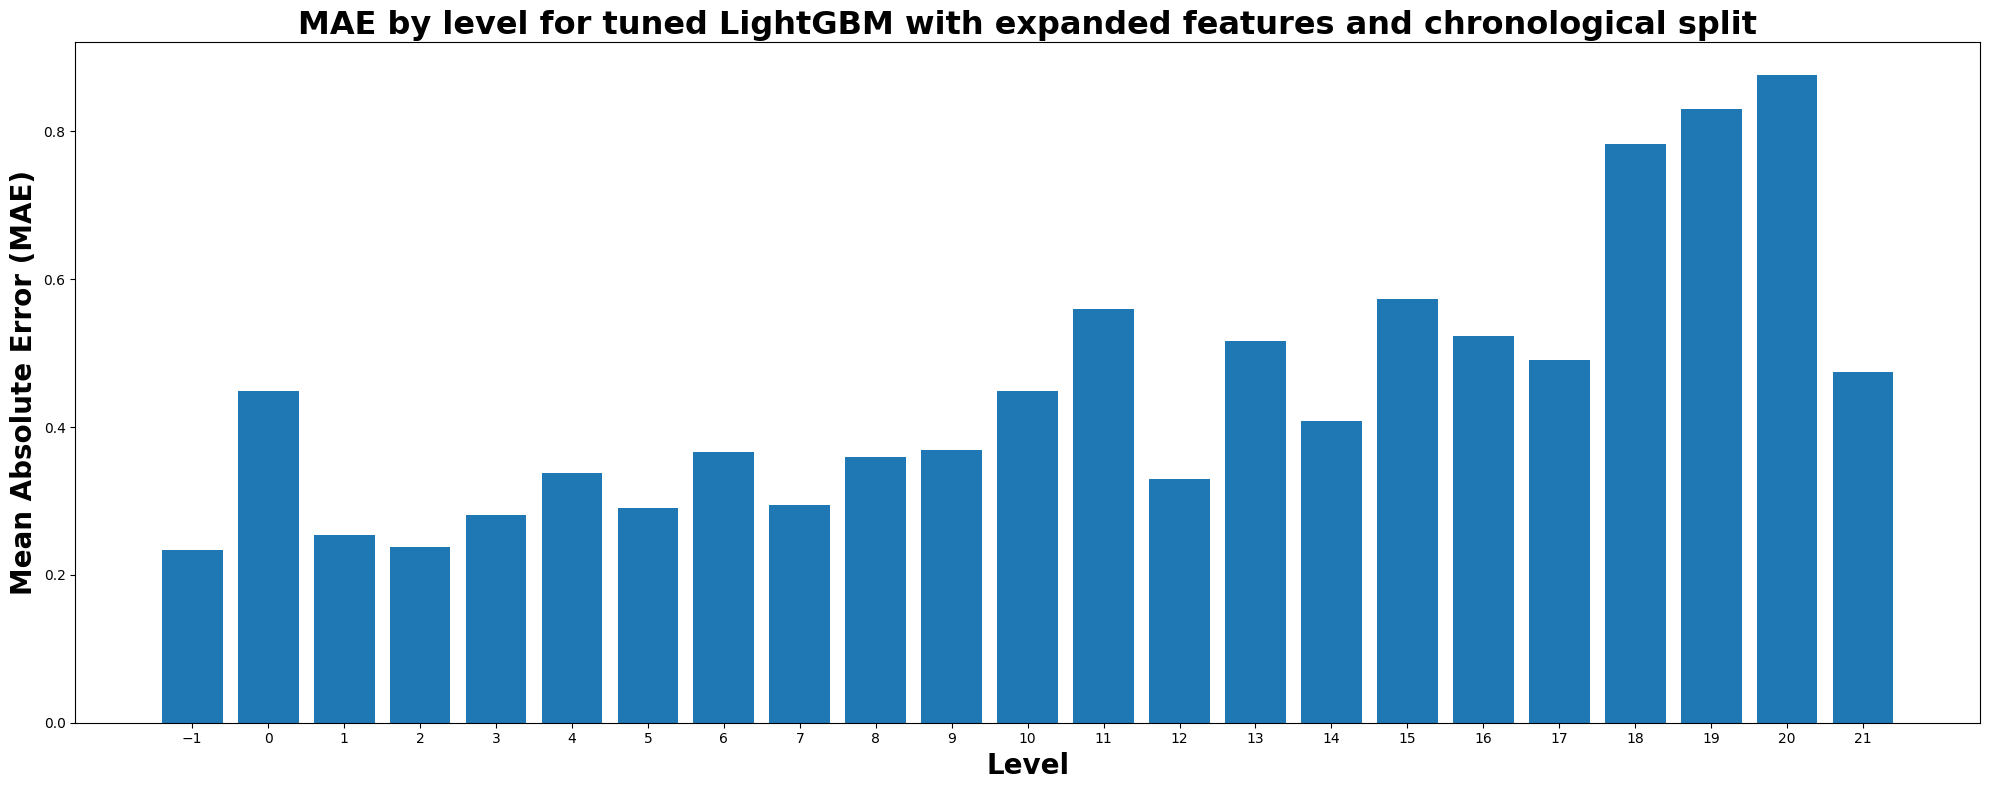

In [71]:
plot_mae_by_level(
    y_test,
    y_pred_test,
    title="MAE by level for tuned LightGBM with expanded features and chronological split",
)

In [72]:
predict = lgb_tuned.predict(X_test)
evaluate_round_predictions([0.5, 0.33, 0.45], y_test, predict)

Default:
RMSE: 0.59

Round type: 0.5
RMSE: 0.63

Round type: 0.33
RMSE: 0.64

Round type: 0.45
RMSE: 0.64



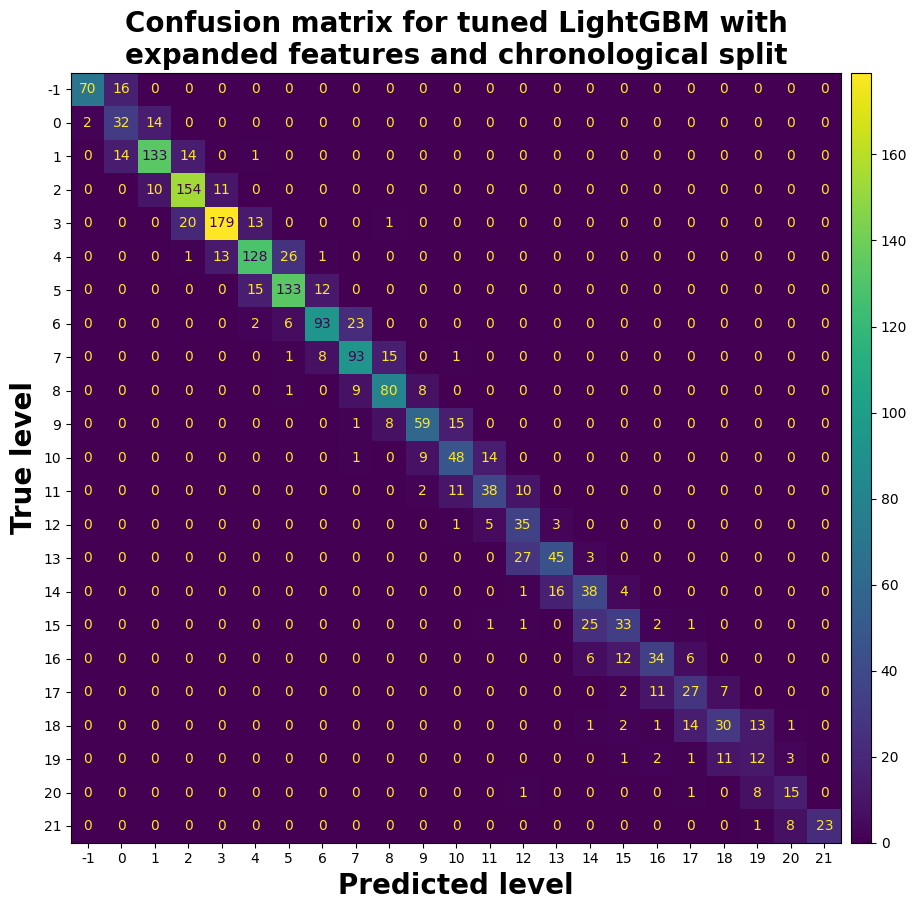

In [73]:
plot_confusion_matrix(
    predict,
    y_test,
    title="Confusion matrix for tuned LightGBM with\nexpanded features and chronological split",
)

## Random split

In [74]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)
lgb_eval = lgb.Dataset(X_test_random_split, y_test_random_split, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 465
[LightGBM] [Info] Number of data points in the train set: 2767, number of used features: 13
[LightGBM] [Info] Start training from score 7.220455
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's l2: 0.17368	valid_0's l1: 0.277924


In [75]:
y_pred_train = gbm.predict(X_train_random_split, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test_random_split, num_iteration=gbm.best_iteration)

In [76]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


rmse = mean_squared_error(y_test_random_split, y_pred_test, squared=False)
mae = mean_absolute_error(y_test_random_split, y_pred_test)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 0.42
MAE: 0.28


In [77]:
results.loc[2] = ["random", "default", "expanded", rmse, mae]

###### MAE by level

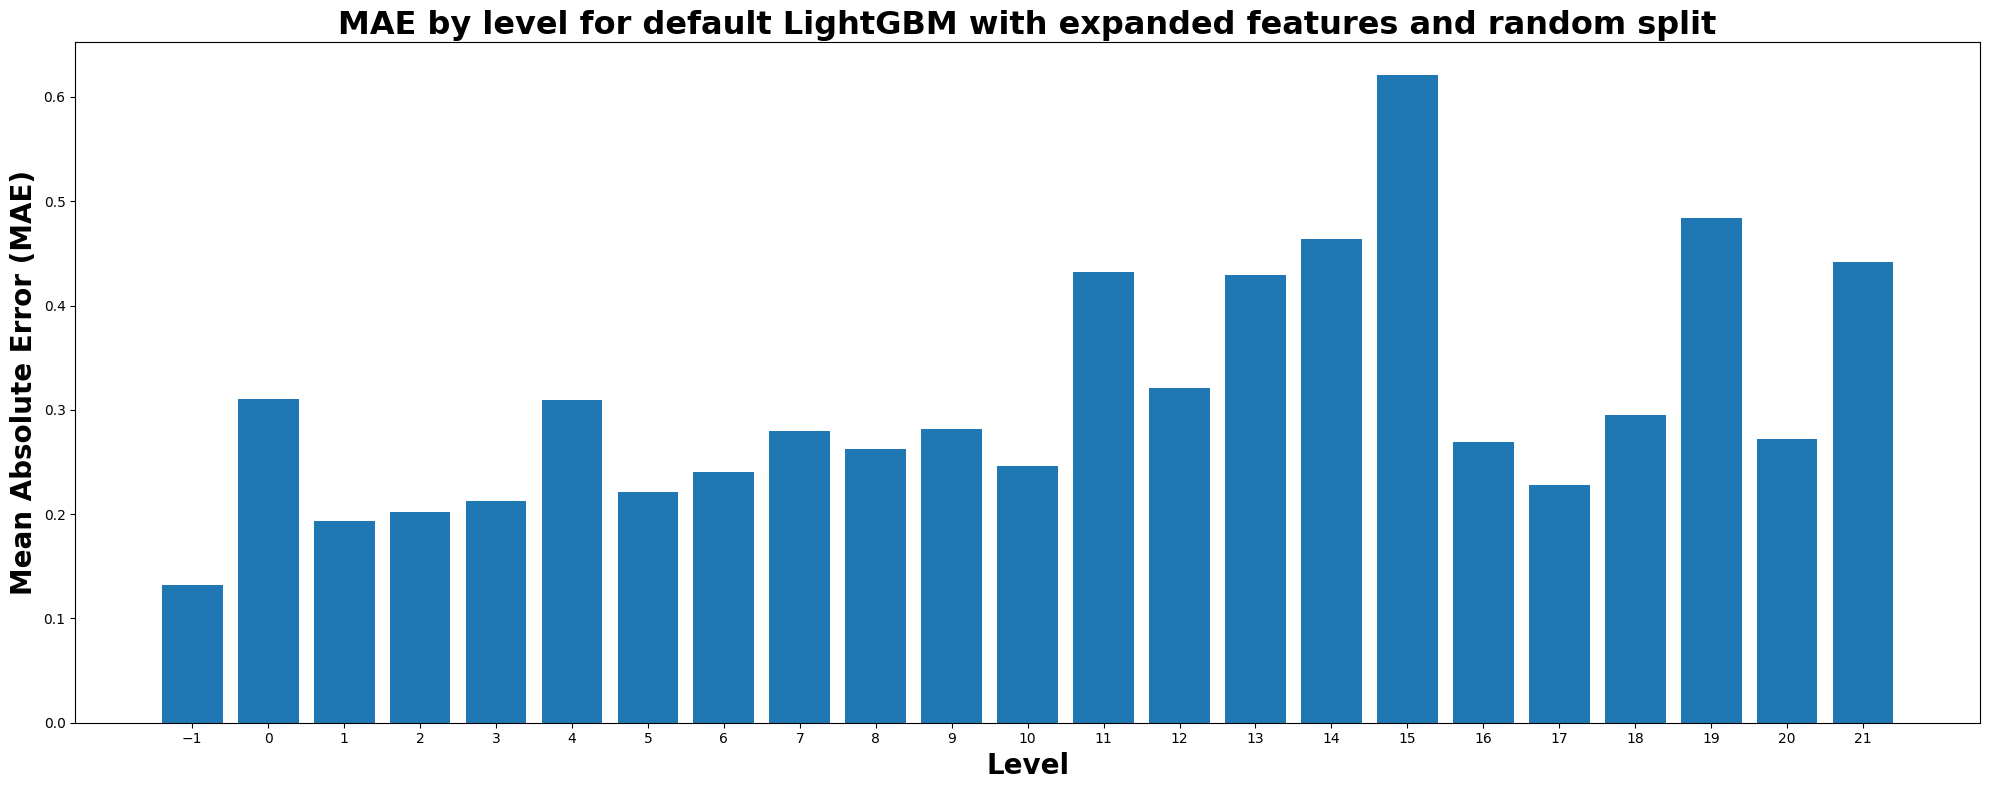

In [78]:
plot_mae_by_level(
    y_test_random_split,
    y_pred_test,
    title="MAE by level for default LightGBM with expanded features and random split",
)

In [79]:
evaluate_round_predictions([0.5, 0.33, 0.45], y_test_random_split, y_pred_test)

Default:
RMSE: 0.42

Round type: 0.5
RMSE: 0.45

Round type: 0.33
RMSE: 0.49

Round type: 0.45
RMSE: 0.46



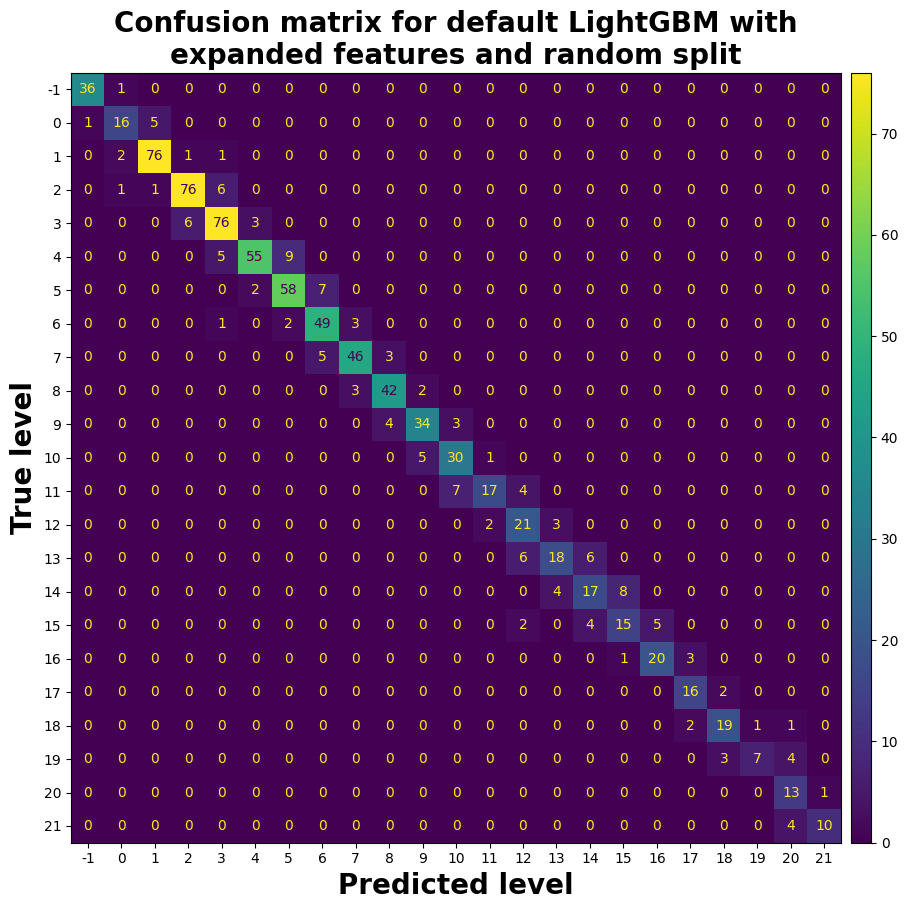

In [80]:
plot_confusion_matrix(
    y_pred_test,
    y_test_random_split,
    title="Confusion matrix for default LightGBM with\nexpanded features and random split",
)

### Tuning

In [81]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-11-26 22:35:52,221] A new study created in memory with name: no-name-de581a39-5d50-4fa3-a5fc-ce261fbce960
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.251486 + 0.0553884
[200]	cv_agg's l2: 0.247298 + 0.0513418
[300]	cv_agg's l2: 0.246812 + 0.0492905


feature_fraction, val_score: 0.246791:  14%|#4        | 1/7 [00:07<00:42,  7.12s/it]

[400]	cv_agg's l2: 0.246886 + 0.04832
Early stopping, best iteration is:
[304]	cv_agg's l2: 0.246791 + 0.0494319
[100]	cv_agg's l2: 0.254121 + 0.0623326
[200]	cv_agg's l2: 0.249515 + 0.0572532
[300]	cv_agg's l2: 0.249118 + 0.0553859


feature_fraction, val_score: 0.246791:  29%|##8       | 2/7 [00:11<00:28,  5.63s/it]

[400]	cv_agg's l2: 0.249959 + 0.0532931
Early stopping, best iteration is:
[304]	cv_agg's l2: 0.246791 + 0.0494319
[100]	cv_agg's l2: 0.252623 + 0.0594542
[200]	cv_agg's l2: 0.247015 + 0.0565846


feature_fraction, val_score: 0.246588:  43%|####2     | 3/7 [00:14<00:17,  4.48s/it]

[300]	cv_agg's l2: 0.247157 + 0.0552507
Early stopping, best iteration is:
[212]	cv_agg's l2: 0.246588 + 0.0564538
[100]	cv_agg's l2: 0.252547 + 0.0610192
[200]	cv_agg's l2: 0.248755 + 0.0585291


feature_fraction, val_score: 0.246588:  57%|#####7    | 4/7 [00:17<00:11,  3.88s/it]

[300]	cv_agg's l2: 0.248706 + 0.0568489
Early stopping, best iteration is:
[212]	cv_agg's l2: 0.246588 + 0.0564538
[100]	cv_agg's l2: 0.25146 + 0.0573058
[200]	cv_agg's l2: 0.246348 + 0.0523375
[300]	cv_agg's l2: 0.245442 + 0.0490886


feature_fraction, val_score: 0.244966:  71%|#######1  | 5/7 [00:22<00:08,  4.04s/it]

Early stopping, best iteration is:
[286]	cv_agg's l2: 0.244966 + 0.0496263
[100]	cv_agg's l2: 0.246366 + 0.0448928
[200]	cv_agg's l2: 0.243973 + 0.0445878


feature_fraction, val_score: 0.243588:  86%|########5 | 6/7 [00:26<00:04,  4.01s/it]

Early stopping, best iteration is:
[190]	cv_agg's l2: 0.243588 + 0.0445101
[100]	cv_agg's l2: 0.242583 + 0.0381769
[200]	cv_agg's l2: 0.239755 + 0.0402769


feature_fraction, val_score: 0.238934: 100%|##########| 7/7 [00:30<00:00,  4.37s/it]


Early stopping, best iteration is:
[155]	cv_agg's l2: 0.238934 + 0.0395123


num_leaves, val_score: 0.238934:   0%|          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.243735 + 0.040663
[200]	cv_agg's l2: 0.243058 + 0.0404095


num_leaves, val_score: 0.238934:   5%|5         | 1/20 [00:09<03:01,  9.57s/it]

Early stopping, best iteration is:
[155]	cv_agg's l2: 0.238934 + 0.0395123
[100]	cv_agg's l2: 0.243735 + 0.040663
[200]	cv_agg's l2: 0.243058 + 0.0404095


num_leaves, val_score: 0.238934:  10%|#         | 2/20 [00:19<02:56,  9.82s/it]

Early stopping, best iteration is:
[155]	cv_agg's l2: 0.238934 + 0.0395123
[100]	cv_agg's l2: 0.243735 + 0.040663
[200]	cv_agg's l2: 0.243058 + 0.0404095


num_leaves, val_score: 0.238934:  15%|#5        | 3/20 [00:29<02:45,  9.76s/it]

Early stopping, best iteration is:
[155]	cv_agg's l2: 0.238934 + 0.0395123
[100]	cv_agg's l2: 0.32372 + 0.0429909
[200]	cv_agg's l2: 0.286915 + 0.040935


num_leaves, val_score: 0.238934:  20%|##        | 4/20 [00:30<01:41,  6.35s/it]

Early stopping, best iteration is:
[155]	cv_agg's l2: 0.238934 + 0.0395123
[100]	cv_agg's l2: 0.243735 + 0.040663
[200]	cv_agg's l2: 0.243058 + 0.0404095


num_leaves, val_score: 0.238934:  25%|##5       | 5/20 [00:40<01:54,  7.60s/it]

Early stopping, best iteration is:
[155]	cv_agg's l2: 0.238934 + 0.0395123
[100]	cv_agg's l2: 0.243735 + 0.040663
[200]	cv_agg's l2: 0.243058 + 0.0404095


num_leaves, val_score: 0.238934:  30%|###       | 6/20 [00:54<02:19,  9.98s/it]

Early stopping, best iteration is:
[155]	cv_agg's l2: 0.238934 + 0.0395123
[100]	cv_agg's l2: 0.24261 + 0.0406308
[200]	cv_agg's l2: 0.239381 + 0.0397291


num_leaves, val_score: 0.238934:  35%|###5      | 7/20 [01:00<01:52,  8.65s/it]

Early stopping, best iteration is:
[155]	cv_agg's l2: 0.238934 + 0.0395123
[100]	cv_agg's l2: 0.24261 + 0.0406308
[200]	cv_agg's l2: 0.239381 + 0.0397291


num_leaves, val_score: 0.238934:  40%|####      | 8/20 [01:04<01:25,  7.09s/it]

Early stopping, best iteration is:
[155]	cv_agg's l2: 0.238934 + 0.0395123
[100]	cv_agg's l2: 0.243874 + 0.038455
[200]	cv_agg's l2: 0.243793 + 0.039999


num_leaves, val_score: 0.238934:  45%|####5     | 9/20 [01:09<01:12,  6.56s/it]

Early stopping, best iteration is:
[155]	cv_agg's l2: 0.238934 + 0.0395123
[100]	cv_agg's l2: 0.242401 + 0.0391359
[200]	cv_agg's l2: 0.242299 + 0.0393333


num_leaves, val_score: 0.238934:  50%|#####     | 10/20 [01:13<00:57,  5.79s/it]

Early stopping, best iteration is:
[155]	cv_agg's l2: 0.238934 + 0.0395123
[100]	cv_agg's l2: 0.242771 + 0.0405233
[200]	cv_agg's l2: 0.242916 + 0.0420853


num_leaves, val_score: 0.238934:  55%|#####5    | 11/20 [01:18<00:49,  5.51s/it]

Early stopping, best iteration is:
[155]	cv_agg's l2: 0.238934 + 0.0395123
[100]	cv_agg's l2: 0.243735 + 0.040663
[200]	cv_agg's l2: 0.243058 + 0.0404095


num_leaves, val_score: 0.238934:  60%|######    | 12/20 [01:24<00:44,  5.55s/it]

Early stopping, best iteration is:
[155]	cv_agg's l2: 0.238934 + 0.0395123
[100]	cv_agg's l2: 0.298392 + 0.042626


num_leaves, val_score: 0.238934:  65%|######5   | 13/20 [01:25<00:29,  4.15s/it]

[200]	cv_agg's l2: 0.271296 + 0.0373326
Early stopping, best iteration is:
[155]	cv_agg's l2: 0.238934 + 0.0395123
[100]	cv_agg's l2: 0.243735 + 0.040663
[200]	cv_agg's l2: 0.243058 + 0.0404095


num_leaves, val_score: 0.238934:  70%|#######   | 14/20 [01:30<00:26,  4.49s/it]

Early stopping, best iteration is:
[155]	cv_agg's l2: 0.238934 + 0.0395123
[100]	cv_agg's l2: 0.24261 + 0.0406308
[200]	cv_agg's l2: 0.239381 + 0.0397291


num_leaves, val_score: 0.238934:  75%|#######5  | 15/20 [01:32<00:18,  3.77s/it]

Early stopping, best iteration is:
[155]	cv_agg's l2: 0.238934 + 0.0395123
[100]	cv_agg's l2: 0.243191 + 0.0419431
[200]	cv_agg's l2: 0.242022 + 0.041689


num_leaves, val_score: 0.238934:  80%|########  | 16/20 [01:36<00:14,  3.65s/it]

Early stopping, best iteration is:
[155]	cv_agg's l2: 0.238934 + 0.0395123
[100]	cv_agg's l2: 0.243735 + 0.040663
[200]	cv_agg's l2: 0.243058 + 0.0404095


num_leaves, val_score: 0.238934:  85%|########5 | 17/20 [01:40<00:11,  3.83s/it]

Early stopping, best iteration is:
[155]	cv_agg's l2: 0.238934 + 0.0395123
[100]	cv_agg's l2: 0.241495 + 0.0388519
[200]	cv_agg's l2: 0.237869 + 0.0383607


num_leaves, val_score: 0.237733:  90%|######### | 18/20 [01:43<00:07,  3.77s/it]

Early stopping, best iteration is:
[197]	cv_agg's l2: 0.237733 + 0.0382872
[100]	cv_agg's l2: 0.243735 + 0.040663
[200]	cv_agg's l2: 0.243058 + 0.0404095


num_leaves, val_score: 0.237733:  95%|#########5| 19/20 [01:49<00:04,  4.16s/it]

Early stopping, best iteration is:
[197]	cv_agg's l2: 0.237733 + 0.0382872
[100]	cv_agg's l2: 0.241837 + 0.0391404
[200]	cv_agg's l2: 0.2413 + 0.0398895


num_leaves, val_score: 0.237733: 100%|##########| 20/20 [01:53<00:00,  5.69s/it]


Early stopping, best iteration is:
[197]	cv_agg's l2: 0.237733 + 0.0382872


bagging, val_score: 0.237733:   0%|          | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.250702 + 0.0358922
[200]	cv_agg's l2: 0.249879 + 0.0346348


bagging, val_score: 0.237733:  10%|#         | 1/10 [00:03<00:33,  3.75s/it]

Early stopping, best iteration is:
[197]	cv_agg's l2: 0.237733 + 0.0382872
[100]	cv_agg's l2: 0.244288 + 0.0378017
[200]	cv_agg's l2: 0.24145 + 0.0365588


bagging, val_score: 0.237733:  20%|##        | 2/10 [00:07<00:29,  3.64s/it]

Early stopping, best iteration is:
[197]	cv_agg's l2: 0.237733 + 0.0382872
[100]	cv_agg's l2: 0.257691 + 0.0300899
[200]	cv_agg's l2: 0.249257 + 0.0322481


bagging, val_score: 0.237733:  30%|###       | 3/10 [00:10<00:24,  3.54s/it]

Early stopping, best iteration is:
[197]	cv_agg's l2: 0.237733 + 0.0382872
[100]	cv_agg's l2: 0.241339 + 0.0377581
[200]	cv_agg's l2: 0.238031 + 0.0389401


bagging, val_score: 0.237641:  40%|####      | 4/10 [00:14<00:22,  3.75s/it]

[300]	cv_agg's l2: 0.23965 + 0.0377489
Early stopping, best iteration is:
[207]	cv_agg's l2: 0.237641 + 0.0387787
[100]	cv_agg's l2: 0.242279 + 0.0399258
[200]	cv_agg's l2: 0.240165 + 0.0391613


bagging, val_score: 0.237641:  50%|#####     | 5/10 [00:18<00:18,  3.75s/it]

[300]	cv_agg's l2: 0.241293 + 0.0382776
Early stopping, best iteration is:
[207]	cv_agg's l2: 0.237641 + 0.0387787
[100]	cv_agg's l2: 0.241495 + 0.0388519
[200]	cv_agg's l2: 0.237869 + 0.0383607


bagging, val_score: 0.237641:  60%|######    | 6/10 [00:21<00:13,  3.49s/it]

[300]	cv_agg's l2: 0.239563 + 0.0381022
Early stopping, best iteration is:
[207]	cv_agg's l2: 0.237641 + 0.0387787
[100]	cv_agg's l2: 0.241967 + 0.0383305
[200]	cv_agg's l2: 0.238848 + 0.0375628


bagging, val_score: 0.237641:  70%|#######   | 7/10 [00:25<00:10,  3.59s/it]

[300]	cv_agg's l2: 0.239954 + 0.0372816
Early stopping, best iteration is:
[207]	cv_agg's l2: 0.237641 + 0.0387787
[100]	cv_agg's l2: 0.245228 + 0.0398255
[200]	cv_agg's l2: 0.241103 + 0.0400836


bagging, val_score: 0.237641:  80%|########  | 8/10 [00:28<00:07,  3.52s/it]

[300]	cv_agg's l2: 0.24229 + 0.0391075
Early stopping, best iteration is:
[207]	cv_agg's l2: 0.237641 + 0.0387787
[100]	cv_agg's l2: 0.240092 + 0.037425
[200]	cv_agg's l2: 0.235997 + 0.0377642
[300]	cv_agg's l2: 0.236464 + 0.0371513


bagging, val_score: 0.235438:  90%|######### | 9/10 [00:32<00:03,  3.75s/it]

Early stopping, best iteration is:
[244]	cv_agg's l2: 0.235438 + 0.0378261
[100]	cv_agg's l2: 0.24453 + 0.0394896
[200]	cv_agg's l2: 0.24264 + 0.0385094
[300]	cv_agg's l2: 0.243331 + 0.0380368


bagging, val_score: 0.235438: 100%|##########| 10/10 [00:36<00:00,  3.66s/it]


Early stopping, best iteration is:
[244]	cv_agg's l2: 0.235438 + 0.0378261


feature_fraction_stage2, val_score: 0.235438:   0%|          | 0/3 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.244542 + 0.048435
[200]	cv_agg's l2: 0.24232 + 0.0479506
[300]	cv_agg's l2: 0.243111 + 0.0474169


feature_fraction_stage2, val_score: 0.235438:  33%|###3      | 1/3 [00:03<00:07,  3.92s/it]

Early stopping, best iteration is:
[244]	cv_agg's l2: 0.235438 + 0.0378261
[100]	cv_agg's l2: 0.240092 + 0.037425
[200]	cv_agg's l2: 0.235997 + 0.0377642
[300]	cv_agg's l2: 0.236464 + 0.0371513


feature_fraction_stage2, val_score: 0.235438:  67%|######6   | 2/3 [00:07<00:03,  3.82s/it]

Early stopping, best iteration is:
[244]	cv_agg's l2: 0.235438 + 0.0378261
[100]	cv_agg's l2: 0.244542 + 0.048435
[200]	cv_agg's l2: 0.24232 + 0.0479506
[300]	cv_agg's l2: 0.243111 + 0.0474169


feature_fraction_stage2, val_score: 0.235438: 100%|##########| 3/3 [00:11<00:00,  3.98s/it]


Early stopping, best iteration is:
[244]	cv_agg's l2: 0.235438 + 0.0378261


regularization_factors, val_score: 0.235438:   0%|          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.246172 + 0.0391915
[200]	cv_agg's l2: 0.24064 + 0.038533
[300]	cv_agg's l2: 0.23957 + 0.038069


regularization_factors, val_score: 0.235438:   5%|5         | 1/20 [00:03<01:11,  3.74s/it]

Early stopping, best iteration is:
[244]	cv_agg's l2: 0.235438 + 0.0378261
[100]	cv_agg's l2: 0.252347 + 0.0384882
[200]	cv_agg's l2: 0.242074 + 0.0363362
[300]	cv_agg's l2: 0.241882 + 0.0350602


regularization_factors, val_score: 0.235438:  10%|#         | 2/20 [00:07<01:10,  3.92s/it]

Early stopping, best iteration is:
[244]	cv_agg's l2: 0.235438 + 0.0378261
[100]	cv_agg's l2: 0.287915 + 0.046558
[200]	cv_agg's l2: 0.277046 + 0.0450485


regularization_factors, val_score: 0.235438:  15%|#5        | 3/20 [00:09<00:49,  2.89s/it]

[300]	cv_agg's l2: 0.274702 + 0.0447786
Early stopping, best iteration is:
[244]	cv_agg's l2: 0.235438 + 0.0378261
[100]	cv_agg's l2: 0.242846 + 0.0386262
[200]	cv_agg's l2: 0.239343 + 0.0403074
[300]	cv_agg's l2: 0.239575 + 0.0389338


regularization_factors, val_score: 0.235438:  20%|##        | 4/20 [00:14<00:57,  3.61s/it]

Early stopping, best iteration is:
[244]	cv_agg's l2: 0.235438 + 0.0378261
[100]	cv_agg's l2: 0.238817 + 0.0368016
[200]	cv_agg's l2: 0.236843 + 0.0353878
[300]	cv_agg's l2: 0.2376 + 0.0347737


regularization_factors, val_score: 0.235438:  25%|##5       | 5/20 [00:17<00:54,  3.62s/it]

Early stopping, best iteration is:
[244]	cv_agg's l2: 0.235438 + 0.0378261
[100]	cv_agg's l2: 0.239947 + 0.0373457
[200]	cv_agg's l2: 0.237869 + 0.0379966
[300]	cv_agg's l2: 0.239728 + 0.037959


regularization_factors, val_score: 0.235438:  30%|###       | 6/20 [00:21<00:53,  3.81s/it]

Early stopping, best iteration is:
[244]	cv_agg's l2: 0.235438 + 0.0378261
[100]	cv_agg's l2: 0.238817 + 0.0368016
[200]	cv_agg's l2: 0.236843 + 0.0353879
[300]	cv_agg's l2: 0.237599 + 0.0347738


regularization_factors, val_score: 0.235438:  35%|###5      | 7/20 [00:25<00:49,  3.81s/it]

Early stopping, best iteration is:
[244]	cv_agg's l2: 0.235438 + 0.0378261
[100]	cv_agg's l2: 0.240322 + 0.0378962
[200]	cv_agg's l2: 0.237665 + 0.0385482
[300]	cv_agg's l2: 0.23879 + 0.037365


regularization_factors, val_score: 0.235438:  40%|####      | 8/20 [00:30<00:47,  3.97s/it]

Early stopping, best iteration is:
[244]	cv_agg's l2: 0.235438 + 0.0378261
[100]	cv_agg's l2: 0.239283 + 0.037836
[200]	cv_agg's l2: 0.23642 + 0.0372376
[300]	cv_agg's l2: 0.236061 + 0.036831


regularization_factors, val_score: 0.235438:  45%|####5     | 9/20 [00:33<00:41,  3.75s/it]

Early stopping, best iteration is:
[244]	cv_agg's l2: 0.235438 + 0.0378261
[100]	cv_agg's l2: 0.240622 + 0.0375428
[200]	cv_agg's l2: 0.238214 + 0.0377095
[300]	cv_agg's l2: 0.239114 + 0.037421


regularization_factors, val_score: 0.235438:  50%|#####     | 10/20 [00:37<00:38,  3.89s/it]

Early stopping, best iteration is:
[244]	cv_agg's l2: 0.235438 + 0.0378261
[100]	cv_agg's l2: 0.24074 + 0.036867
[200]	cv_agg's l2: 0.236719 + 0.0378286
[300]	cv_agg's l2: 0.237741 + 0.0376974


regularization_factors, val_score: 0.235438:  55%|#####5    | 11/20 [00:41<00:36,  4.02s/it]

Early stopping, best iteration is:
[244]	cv_agg's l2: 0.235438 + 0.0378261
[100]	cv_agg's l2: 0.24167 + 0.0362944
[200]	cv_agg's l2: 0.239026 + 0.0372393
[300]	cv_agg's l2: 0.240025 + 0.0368524


regularization_factors, val_score: 0.235438:  60%|######    | 12/20 [00:46<00:34,  4.25s/it]

Early stopping, best iteration is:
[244]	cv_agg's l2: 0.235438 + 0.0378261
[100]	cv_agg's l2: 0.239392 + 0.0397644
[200]	cv_agg's l2: 0.236978 + 0.0386634
[300]	cv_agg's l2: 0.237821 + 0.0383699


regularization_factors, val_score: 0.235438:  65%|######5   | 13/20 [00:50<00:29,  4.15s/it]

Early stopping, best iteration is:
[244]	cv_agg's l2: 0.235438 + 0.0378261
[100]	cv_agg's l2: 0.239902 + 0.0363241
[200]	cv_agg's l2: 0.237172 + 0.0368659
[300]	cv_agg's l2: 0.238051 + 0.0373297


regularization_factors, val_score: 0.235438:  70%|#######   | 14/20 [00:55<00:25,  4.26s/it]

Early stopping, best iteration is:
[244]	cv_agg's l2: 0.235438 + 0.0378261
[100]	cv_agg's l2: 0.239119 + 0.0381338
[200]	cv_agg's l2: 0.235738 + 0.0381825
[300]	cv_agg's l2: 0.23558 + 0.037962


regularization_factors, val_score: 0.234959:  75%|#######5  | 15/20 [00:59<00:22,  4.42s/it]

Early stopping, best iteration is:
[267]	cv_agg's l2: 0.234959 + 0.0386325
[100]	cv_agg's l2: 0.239021 + 0.0375895
[200]	cv_agg's l2: 0.235601 + 0.0369874
[300]	cv_agg's l2: 0.23563 + 0.0366459


regularization_factors, val_score: 0.234959:  80%|########  | 16/20 [01:03<00:17,  4.31s/it]

Early stopping, best iteration is:
[267]	cv_agg's l2: 0.234959 + 0.0386325
[100]	cv_agg's l2: 0.240875 + 0.0378906
[200]	cv_agg's l2: 0.236991 + 0.0382016
[300]	cv_agg's l2: 0.23716 + 0.0381848


regularization_factors, val_score: 0.234959:  85%|########5 | 17/20 [01:08<00:13,  4.49s/it]

Early stopping, best iteration is:
[267]	cv_agg's l2: 0.234959 + 0.0386325
[100]	cv_agg's l2: 0.241113 + 0.0369362
[200]	cv_agg's l2: 0.238769 + 0.0366568
[300]	cv_agg's l2: 0.239023 + 0.035548


regularization_factors, val_score: 0.234959:  90%|######### | 18/20 [01:13<00:08,  4.40s/it]

Early stopping, best iteration is:
[267]	cv_agg's l2: 0.234959 + 0.0386325
[100]	cv_agg's l2: 0.240803 + 0.0385821
[200]	cv_agg's l2: 0.23781 + 0.0381693
[300]	cv_agg's l2: 0.237722 + 0.0381001


regularization_factors, val_score: 0.234959:  95%|#########5| 19/20 [01:17<00:04,  4.36s/it]

Early stopping, best iteration is:
[267]	cv_agg's l2: 0.234959 + 0.0386325
[100]	cv_agg's l2: 0.239029 + 0.0390687
[200]	cv_agg's l2: 0.236043 + 0.0390261
[300]	cv_agg's l2: 0.237407 + 0.0371456


regularization_factors, val_score: 0.234959: 100%|##########| 20/20 [01:21<00:00,  4.10s/it]


Early stopping, best iteration is:
[267]	cv_agg's l2: 0.234959 + 0.0386325


min_data_in_leaf, val_score: 0.234959:   0%|          | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.253031 + 0.0400802
[200]	cv_agg's l2: 0.243537 + 0.0374828
[300]	cv_agg's l2: 0.241192 + 0.0353185


min_data_in_leaf, val_score: 0.234959:  20%|##        | 1/5 [00:03<00:15,  3.92s/it]

Early stopping, best iteration is:
[267]	cv_agg's l2: 0.234959 + 0.0386325
[100]	cv_agg's l2: 0.243927 + 0.0402588
[200]	cv_agg's l2: 0.240973 + 0.0404653
[300]	cv_agg's l2: 0.241987 + 0.0411055


min_data_in_leaf, val_score: 0.234959:  40%|####      | 2/5 [00:08<00:12,  4.21s/it]

Early stopping, best iteration is:
[267]	cv_agg's l2: 0.234959 + 0.0386325
[100]	cv_agg's l2: 0.292216 + 0.0462788
[200]	cv_agg's l2: 0.275925 + 0.0439263
[300]	cv_agg's l2: 0.270094 + 0.0436978


min_data_in_leaf, val_score: 0.234959:  60%|######    | 3/5 [00:11<00:07,  3.60s/it]

Early stopping, best iteration is:
[267]	cv_agg's l2: 0.234959 + 0.0386325
[100]	cv_agg's l2: 0.239737 + 0.0416645
[200]	cv_agg's l2: 0.235502 + 0.0423151
[300]	cv_agg's l2: 0.235367 + 0.0429769


min_data_in_leaf, val_score: 0.234959:  80%|########  | 4/5 [00:15<00:03,  3.71s/it]

Early stopping, best iteration is:
[267]	cv_agg's l2: 0.234959 + 0.0386325
[100]	cv_agg's l2: 0.243091 + 0.0376467
[200]	cv_agg's l2: 0.239648 + 0.0368103
[300]	cv_agg's l2: 0.23962 + 0.0363634


min_data_in_leaf, val_score: 0.234959: 100%|##########| 5/5 [00:19<00:00,  3.98s/it]

Early stopping, best iteration is:
[267]	cv_agg's l2: 0.234959 + 0.0386325


In [82]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.23495904041001178
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 0.03994904280890763
    lambda_l2: 4.687829293422079e-05
    num_leaves: 35
    feature_fraction: 0.4
    bagging_fraction: 0.9823517610183702
    bagging_freq: 3
    min_child_samples: 20


In [83]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [84]:
rmse, mae = assess_regression_model(
    lgb_tuned,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

RMSE train: 0.04
RMSE test: 0.43
MAE test: 0.28



In [85]:
results.loc[3] = ["random", "Optuna", "expanded", rmse, mae]

###### MAE by level

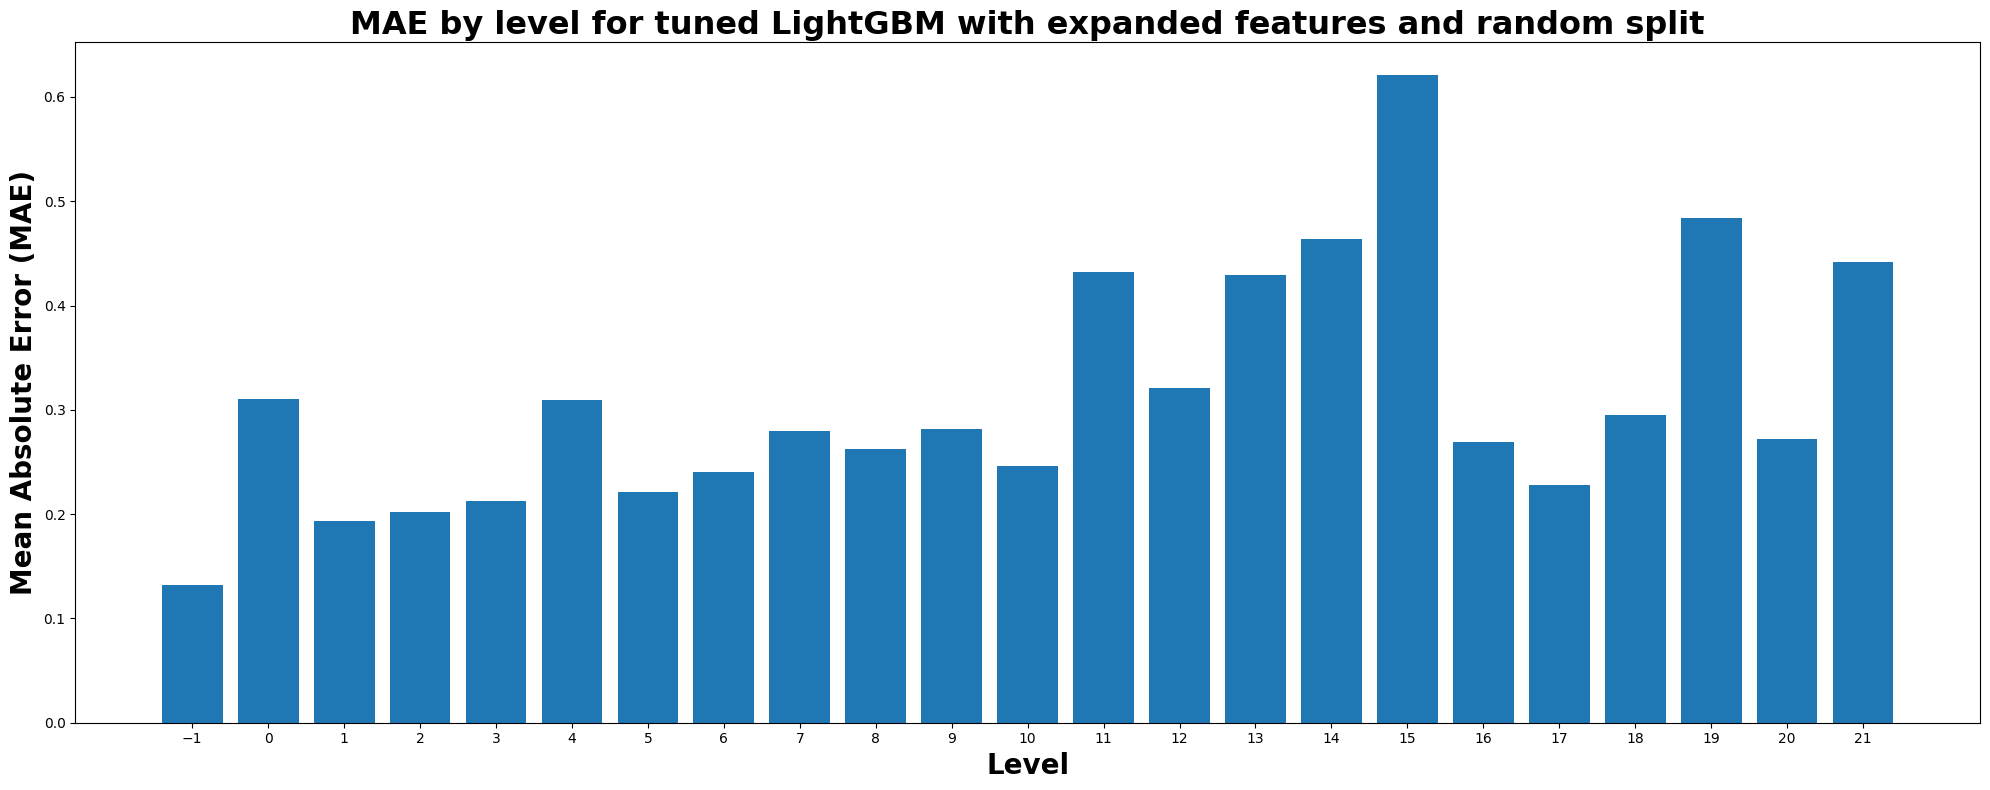

In [86]:
plot_mae_by_level(
    y_test_random_split,
    y_pred_test,
    title="MAE by level for tuned LightGBM with expanded features and random split",
)

In [87]:
predict = lgb_tuned.predict(X_test)
evaluate_round_predictions([0.5, 0.33, 0.45], y_test, predict)

Default:
RMSE: 0.24

Round type: 0.5
RMSE: 0.27

Round type: 0.33
RMSE: 0.27

Round type: 0.45
RMSE: 0.27



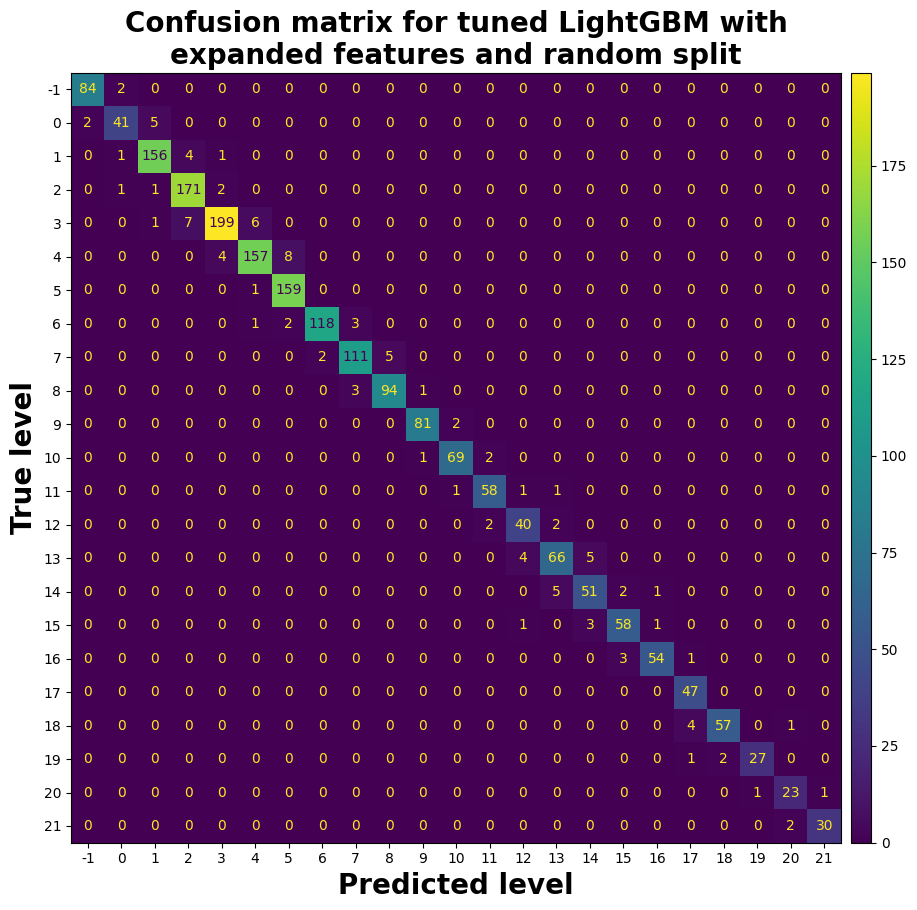

In [88]:
plot_confusion_matrix(
    predict,
    y_test,
    title="Confusion matrix for tuned LightGBM with\nexpanded features and random split",
)

## Summary

In [89]:
results

,Split type,Tuning type,Set of features,RMSE,MAE
0,chronological,default,expanded,0.614277,0.376859
1,chronological,Optuna,expanded,0.590496,0.367707
2,random,default,expanded,0.416749,0.277924
3,random,Optuna,expanded,0.434797,0.280189


In [90]:
from training.results import plot_summary

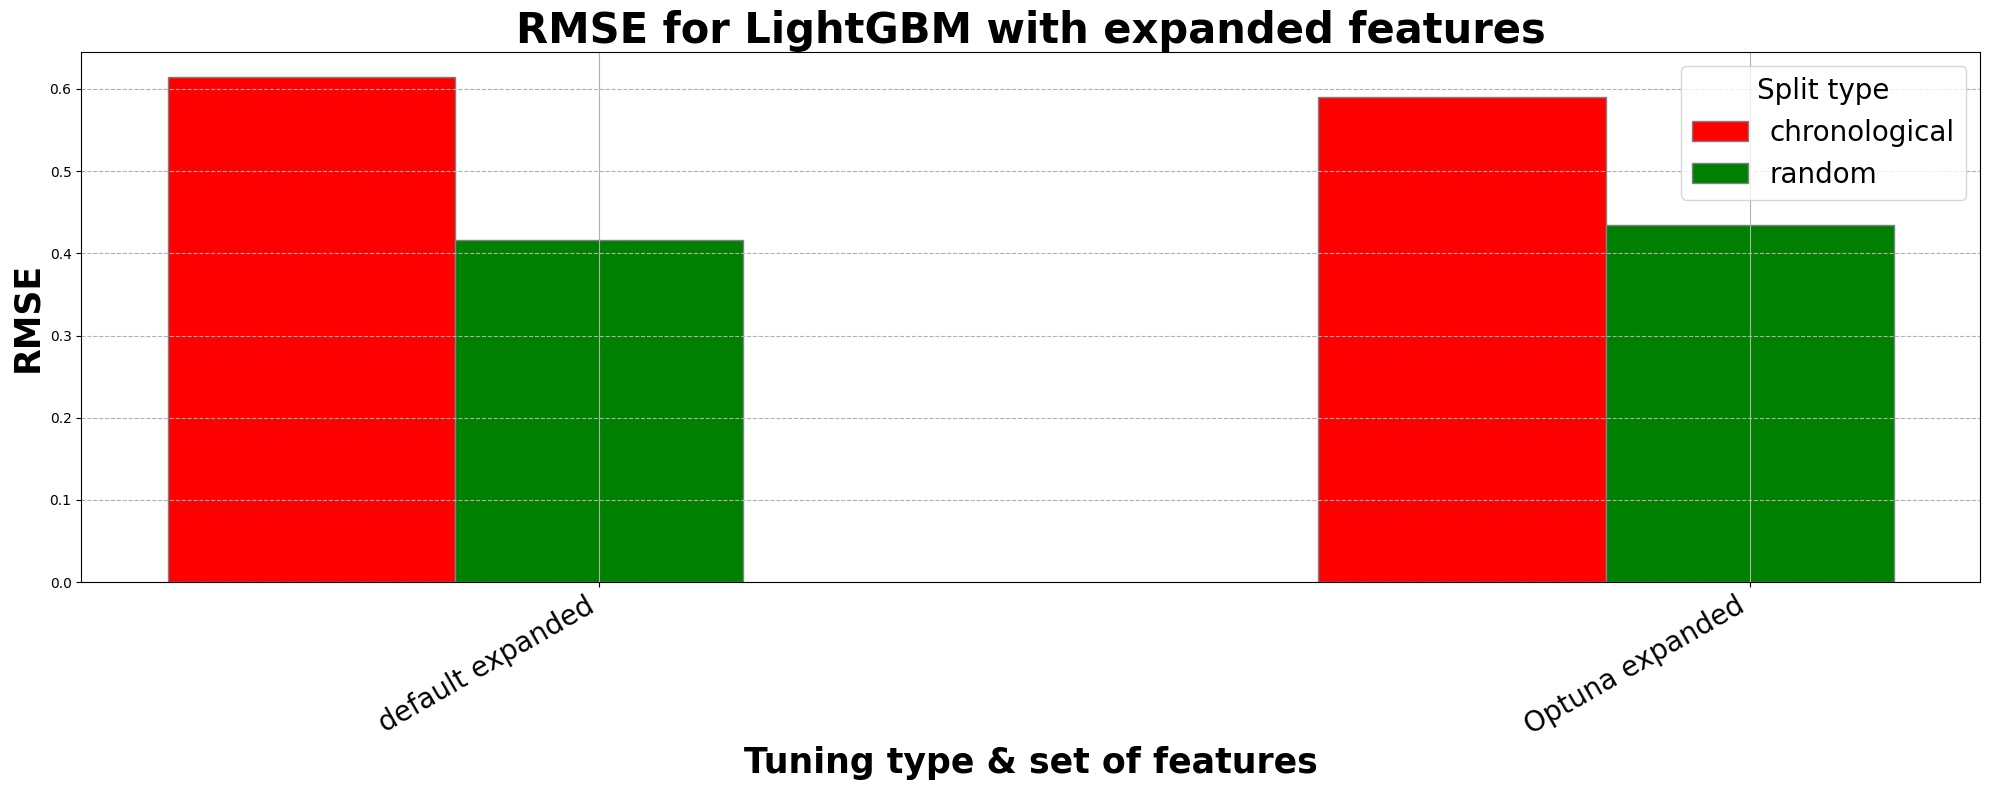

In [91]:
plot_summary(results, "RMSE", title="RMSE for LightGBM with expanded features")

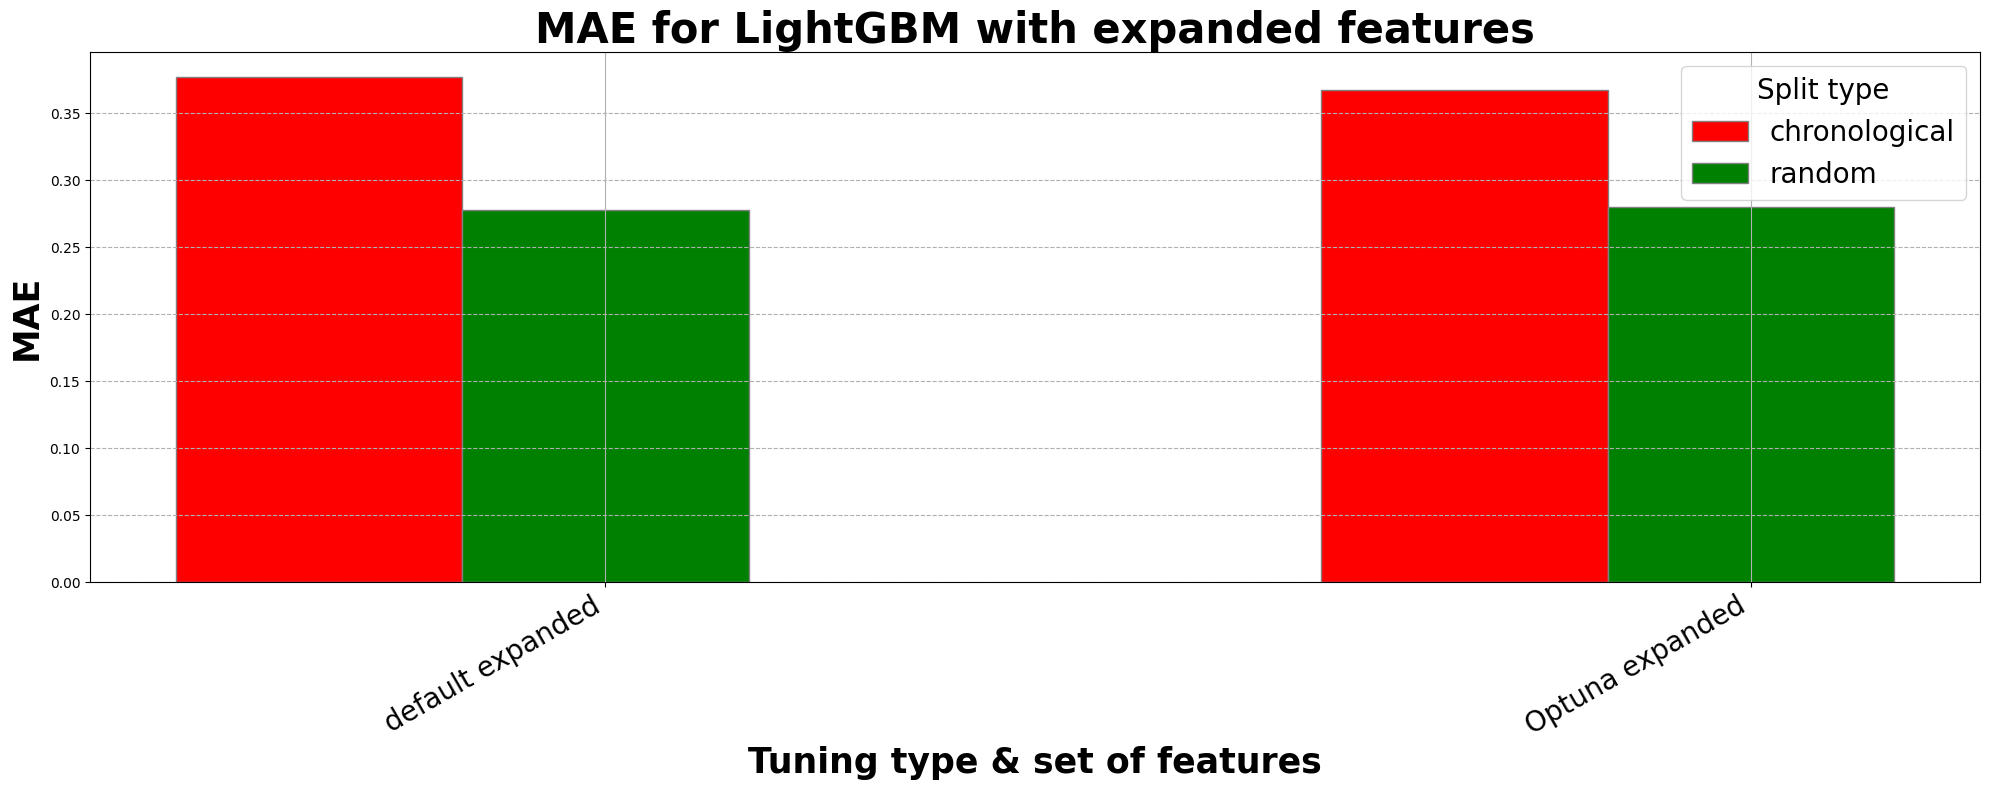

In [92]:
plot_summary(results, "MAE", title="MAE for LightGBM with expanded features")

In [93]:
results.to_csv("./lightgbm_expanded_results.csv")